Import libraries

In [6]:
import time
from urllib.error import HTTPError
from urllib.error import URLError

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4

import requests
import json

import PyCO2SYS as pyco2

from erddapy import ERDDAP
from erddapy.doc_helpers import show_iframe
from erddapy import servers

import cartopy
cartopy.config['data_dir'] = './maps'
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as feat

Retrieve list of erddap servers that have carbon variables, using the CF standard names. Quicker using erddap.com

In [3]:
stdnames=['surface_partial_pressure_of_carbon_dioxide_in_sea_water',
    'fugacity_of_carbon_dioxide_in_sea_water',
    'mole_concentration_of_dissolved_inorganic_carbon_in_sea_water',
    'moles_of_dissolved_inorganic_carbon_per_unit_mass_in_sea_water',
    'sea_water_ph_reported_on_total_scale',
    'sea_water_alkalinity_expressed_as_mole_equivalent']

starttime=time.time()

for s in servers:
    e=ERDDAP(s)
    for v in stdnames:
        kw= {"standard_name": v}
        search_url = e.get_search_url(response="csv", **kw)
        try:
            search=pd.read_csv(search_url)
        except HTTPError:
            pass
            #print("No", stdname, "data in the server", s)
        except URLError:
            pass
            #print(s,"throws an URL error")
        else:
            print(s,"has", {len(set(search["tabledap"].dropna()))},"tabledap datasets with",v)
            print(search[["Dataset ID","Title"]])
            if len(set(search["griddap"].dropna())) > 0:
                print(s,"has", {len(set(search["griddap"].dropna()))},"tabledap datasets with",v)

            

endtime=time.time()-starttime
print("\n Search took", endtime/60,"minutes")


NameError: name 'time' is not defined

Create a dictionary in order to rename all columns to the same

In [7]:
vardict ={'id':'ID', 'doi':'Source_DOI','datevec':'DATEVECTOR','unixd':'UNIXDATE',
          'lat':'LATITUDE','lon':'LONGITUDE','dep':'DEPTH', 'pres':'PRESSURE',
          'temp':'TEMPERATURE', 'tempf':'TEMPERATURE_FLAG',
          'sal':'SALINITY','salf':'SALINITY_FLAG',
          'dic' : 'DIC', 'dicf':'DIC_FLAG', 'dicc':'DIC_CALCULATION',
          'alk': 'ALKALINITY', 'alkf':'ALKALINTY_FLAG', 'alkc':'ALKALINITY_CALCULATION',
          'ph': 'pH_TS','phf': 'pH_FLAG','phc': 'pH_CALCULATION',
          'fco2w':'FCO2_W','fco2wf':'FCO2W_FLAG','fco2wc': 'FCO2_CALCULATION','fco2wac':'ACCURACY_FCO2',}

Get list of datasets that contain pH. Constrain by a particular time frame to avoid downloading a too large dataset

In [8]:
e = ERDDAP(server="EMODNET", protocol='tabledap')
e.response= "csv"
search_url = e.get_search_url(**{
    "standard_name": "sea_water_ph_reported_on_total_scale",
    "min_time": "2019-03-01",
    "max_time": "2019-03-15"})
search = pd.read_csv(search_url)
print(search[["Title","Dataset ID"]].values)

[['EMODnet Physics - Collection of  (PHPH) TimeSeries  Min/Max/Mean -  MultiPointTimeSeriesObservation'
  'EP_ERD_INT_PHPH_AL_TS_MINMAXMEAN']
 ['EMODnet Physics - Collection of Ph (PHPH) Profiles -  MultiPointProfileObservation'
  'EP_ERD_INT_PHPH_AL_PR_NRT']
 ['EMODnet Physics - Collection of Ph (PHPH) TimeSeries -  MultiPointTimeSeriesObservation'
  'EP_ERD_INT_PHPH_AL_TS_NRT']]


Get information about the dataset EP_ERD_INT_PHPH_AL_PR_NRT: variable names, time coverage, pH attributes

In [9]:
e.dataset_id="EP_ERD_INT_PHPH_AL_PR_NRT"

info = pd.read_csv(e.get_info_url())
# List dataset variables
print(", ".join(info.loc[info["Row Type"] == "variable", "Variable Name"]))
print("\n")
# Time coverage
print(info.loc[info["Attribute Name"] == "time_coverage_start", "Value"])
print(info.loc[info["Attribute Name"] == "time_coverage_end", "Value"])
print("\n")
# pH attributes
print(info.loc[info["Variable Name"] == "PHPH", :])
print("\n")
print(info.loc[info["Variable Name"] == "PHPH_QC", :])

EP_PLATFORM_ID, EP_PLATFORM_TYPE, EP_PLATFORM_CODE, EP_PLATFORM_LINK, time, TIME_QC, depth, DEPTH_QC, pres, PRES_QC, latitude, longitude, POSITION_QC, DIRECTION, PHPH, PHPH_QC, PHPH_DM, site_code, platform_code, platform_name, pi_name, area, author, source, contributor_name, contributor_url, data_assembly_center, institution_edmo_code, institution_references, institution, wmo_platform_code


61    1921-09-12T19:00:00Z
Name: Value, dtype: object
60    2021-10-24T06:11:09Z
Name: Value, dtype: object


      Row Type Variable Name        Attribute Name Data Type  \
166   variable          PHPH                   NaN     float   
167  attribute          PHPH            _FillValue     float   
168  attribute          PHPH          actual_range     float   
169  attribute          PHPH    ep_parameter_group    String   
170  attribute          PHPH             long_name    String   
171  attribute          PHPH         missing_value     float   
172  attribute          PHPH                   

Get the data, filtered by only good values of pH. 

In [10]:


# List variables to retrieve
# Axes variables
varaxisname=e.get_var_by_attr(axis=lambda v: v in["X","Y","Z","T"])
varsnames=['PHPH']
varsqcnames=e.get_var_by_attr(long_name="quality flag")
e.variables=varaxisname + varsnames + varsqcnames + ['PHPH_QC', 'platform_name', 'platform_code']

# Constraints
e.constraints= {
    "time>=": "2019-03-01T00:00:00Z",
    "time<=": "2019-03-15T23:59:59Z",
    "PHPH_QC>=": 1, # good data
    "PHPH_QC<=": 2} # probably good data

dtype=object
df_emodnet = e.to_pandas()

# Rename the columns to a common nomenclature
df_emodnet.rename(
    columns={'latitude (degrees_north)': vardict['lat'], 'longitude (degrees_east)': vardict['lon'],
             'pres (dbar)': vardict['pres'], 'time (UTC)': vardict['datevec'],
             'temp_adjusted (degree_Celsius)': vardict['temp'], 'temp_adjusted_qc':vardict['tempf'],
             'PHPH (1)': vardict['ph'], 'ph_in_situ_total_qc': vardict['phf']},
        inplace=True)

# Variables retrieved
print(df_emodnet.columns)
# Size of matrix
print(df_emodnet.shape)

Index(['DATEVECTOR', 'PRESSURE', 'depth (m)', 'LATITUDE', 'LONGITUDE', 'pH_TS',
       'DEPTH_QC (1)', 'PRES_QC (1)', 'TIME_QC (1)', 'POSITION_QC (1)',
       'PHPH_QC (1)', 'platform_name', 'platform_code'],
      dtype='object')
(3095, 13)


In [1]:
# Want to check what type of platform
#print(df_emodnet.platform_name.unique())
#print("\n")
#print(df_emodnet.platform_code.unique())
import requests
import json
url = "https://www.ocean-ops.org/api/preview/data/platform?exp=[%22wmos.wmo=%275904468%27%22]&include=[%22ref%22,%22wmos.wmo%22]}]&include=[%22ptfModel.name%22]"
#data=json.loads(url)
data = requests.get(url)
jdata= json.loads(data.text)
print(jdata['data'][0]['ptfModel']['name'])


APEX


Similarly for IFREMER ERDDAP

In [4]:
i = ERDDAP(server="IFREMER", protocol='tabledap')
search_url = i.get_search_url(response="csv", **{
    "cf_standard_name": "sea_water_ph_reported_on_total_scale", # they use cf_standard
    "min_time": "2019-03-01",
    "max_time": "2019-03-15"})
search = pd.read_csv(search_url)
print(search[["Title","Dataset ID"]].values)

[['Argo Float Measurements' 'ArgoFloats']
 ['Argo float synthetic vertical profiles : BGC data'
  'ArgoFloats-synthetic-BGC']
 ['Global Ocean, In Situ Observation Copernicus (Copernicus Fishing Observing System)'
  'copernicus-fos']
 ['OceanGliders GDAC trajectories' 'OceanGlidersGDACTrajectories']
 ['SDC Baltic Sea Aggregation V2' 'SDC_BAL_AGG_V2']
 ['SDC Mediterranean Sea Aggregation V2' 'SDC_MED_AGG_V2']
 ['SDC North Atlantic Aggregation V2' 'SDC_NATL_AGG_V2']]


Pick the BGC-Argo synthetic profiles dataset

In [5]:
i.dataset_id="ArgoFloats-synthetic-BGC"
i.response="csv"

info = pd.read_csv(i.get_info_url())
# List dataset variables (very long!)

print(info.loc[(info["Attribute Name"] == "long_name") & 
                         (info["Variable Name"].str.contains('(?:^|_)ph(?:_|$)'))
                         , ["Variable Name", "Value"]])
print("\n")
# Time coverage
print(info.loc[info["Attribute Name"] == "time_coverage_start", "Value"])
print(info.loc[info["Attribute Name"] == "time_coverage_end", "Value"])
print("\n")
# pH attributes
print(i.get_var_by_attr(dataset_id="ArgoFloats-synthetic-BGC",cf_standard_name="sea_water_ph_reported_on_total_scale"))
print(info.loc[info["Variable Name"] == "ph_in_situ_total", :])
print("\n")
print(info.loc[info["Variable Name"] == "ph_in_situ_total_qc", :]) 
# QC is a string:

            Variable Name                                              Value
1068               vrs_ph  Voltage difference between reference and sourc...
1081              temp_ph                     Sea temperature from pH sensor
1094                ib_ph                          Base current of pH sensor
1107                vk_ph             Counter electrode voltage of pH sensor
1120                ik_ph             Counter electrode current of pH sensor
1134     ph_in_situ_total                                                 pH
1149      ph_in_situ_free                                                 pH
1162  ph_in_situ_seawater                                                 pH


34    2002-09-08T23:02:51Z
Name: Value, dtype: object
33    2021-10-19T10:58:00Z
Name: Value, dtype: object


['ph_in_situ_total']
       Row Type     Variable Name     Attribute Name Data Type  \
1130   variable  ph_in_situ_total                NaN     float   
1131  attribute  ph_in_situ_total         

In [6]:
i.get_var_by_attr(axis=lambda v: v in["X","Y","Z","T"])

['pres_adjusted', 'time', 'longitude', 'pres', 'latitude']

The dataset has 540 variables in total. Pick only the ones we're interested in..

In [12]:
# Reduce number of variables; total columns is 540
# Axes variables
varaxisname=i.get_var_by_attr(axis=lambda v: v in["X","Y","Z","T"])
varsnames=['ph_in_situ_total', 'ph_in_situ_total_qc']
i.variables=varaxisname + varsnames

i.constraints= {
    "time>=": "2019-03-01T00:00:00Z",
    "time<=": "2019-03-15T23:59:59Z",
    "ph_in_situ_total_qc=~": "(1|2)"} # good data and probably good data
        
dtype=object
df_ifremer = i.to_pandas()
print(df_ifremer.columns)
print(df_ifremer.shape)

Index(['pres_adjusted (decibar)', 'time (UTC)', 'longitude (degrees_east)',
       'pres (decibar)', 'latitude (degrees_north)',
       'ph_in_situ_total (dimensionless)', 'ph_in_situ_total_qc'],
      dtype='object')
(3090, 7)


In [15]:
df_ifremer.rename(
    columns={'latitude (degrees_north)': vardict['lat'], 'longitude (degrees_east)': vardict['lon'],
             'pres_adjusted (decibar)': vardict['pres'], 'time (UTC)': vardict['datevec'],
             'temp_adjusted (degree_Celsius)': vardict['temp'], 'temp_adjusted_qc':vardict['tempf'],
             'ph_in_situ_total (dimensionless)': vardict['ph'], 'ph_in_situ_total_qc': vardict['phf']},
        inplace=True)
df_ifremer['SOURCE']='BGC-Argo (IFREMER)'

Map scatterplot

/usr/local/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


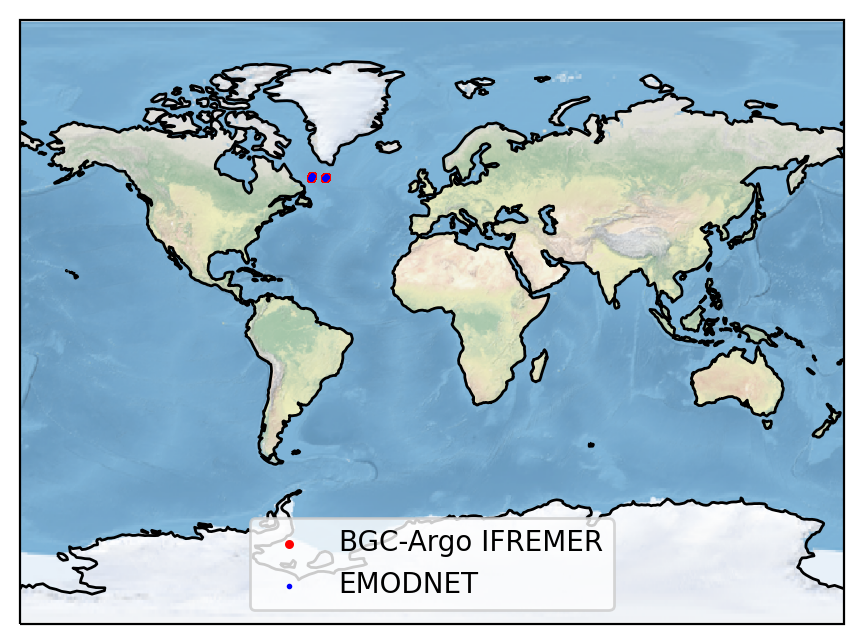

In [22]:
dflist=[df_ifremer,df_emodnet]
df=pd.concat(dflist)

proj=ccrs.cartopy.crs.Miller()
plt.figure(dpi=200)
ax = plt.axes(projection=proj)
if ((df[vardict['lon']].min() < -175) & (df[vardict['lon']].max() > 175) & 
    (df[vardict['lat']].min() <-85) & (df[vardict['lat']].max() > 85)) :
    ax.set_extent([df[vardict['lon']].min()-5,df[vardict['lon']].max()+5, 
                   df[vardict['lat']].max()+5,df[vardict['lat']].min()-5])
ax.stock_img()
ax.coastlines()

sc=ax.scatter(df_ifremer[vardict['lon']],df_ifremer[vardict['lat']],
    c='r',s=5,label='BGC-Argo IFREMER',
    transform=ccrs.PlateCarree())
sc=ax.scatter(df_emodnet[vardict['lon']],df_emodnet[vardict['lat']],
    c='b',s=1,label='EMODNET',
    transform=ccrs.PlateCarree())
    
#plt.colorbar(sc)
ax.legend(loc='lower center')
plt.show()

Latitude-depth scatterplots

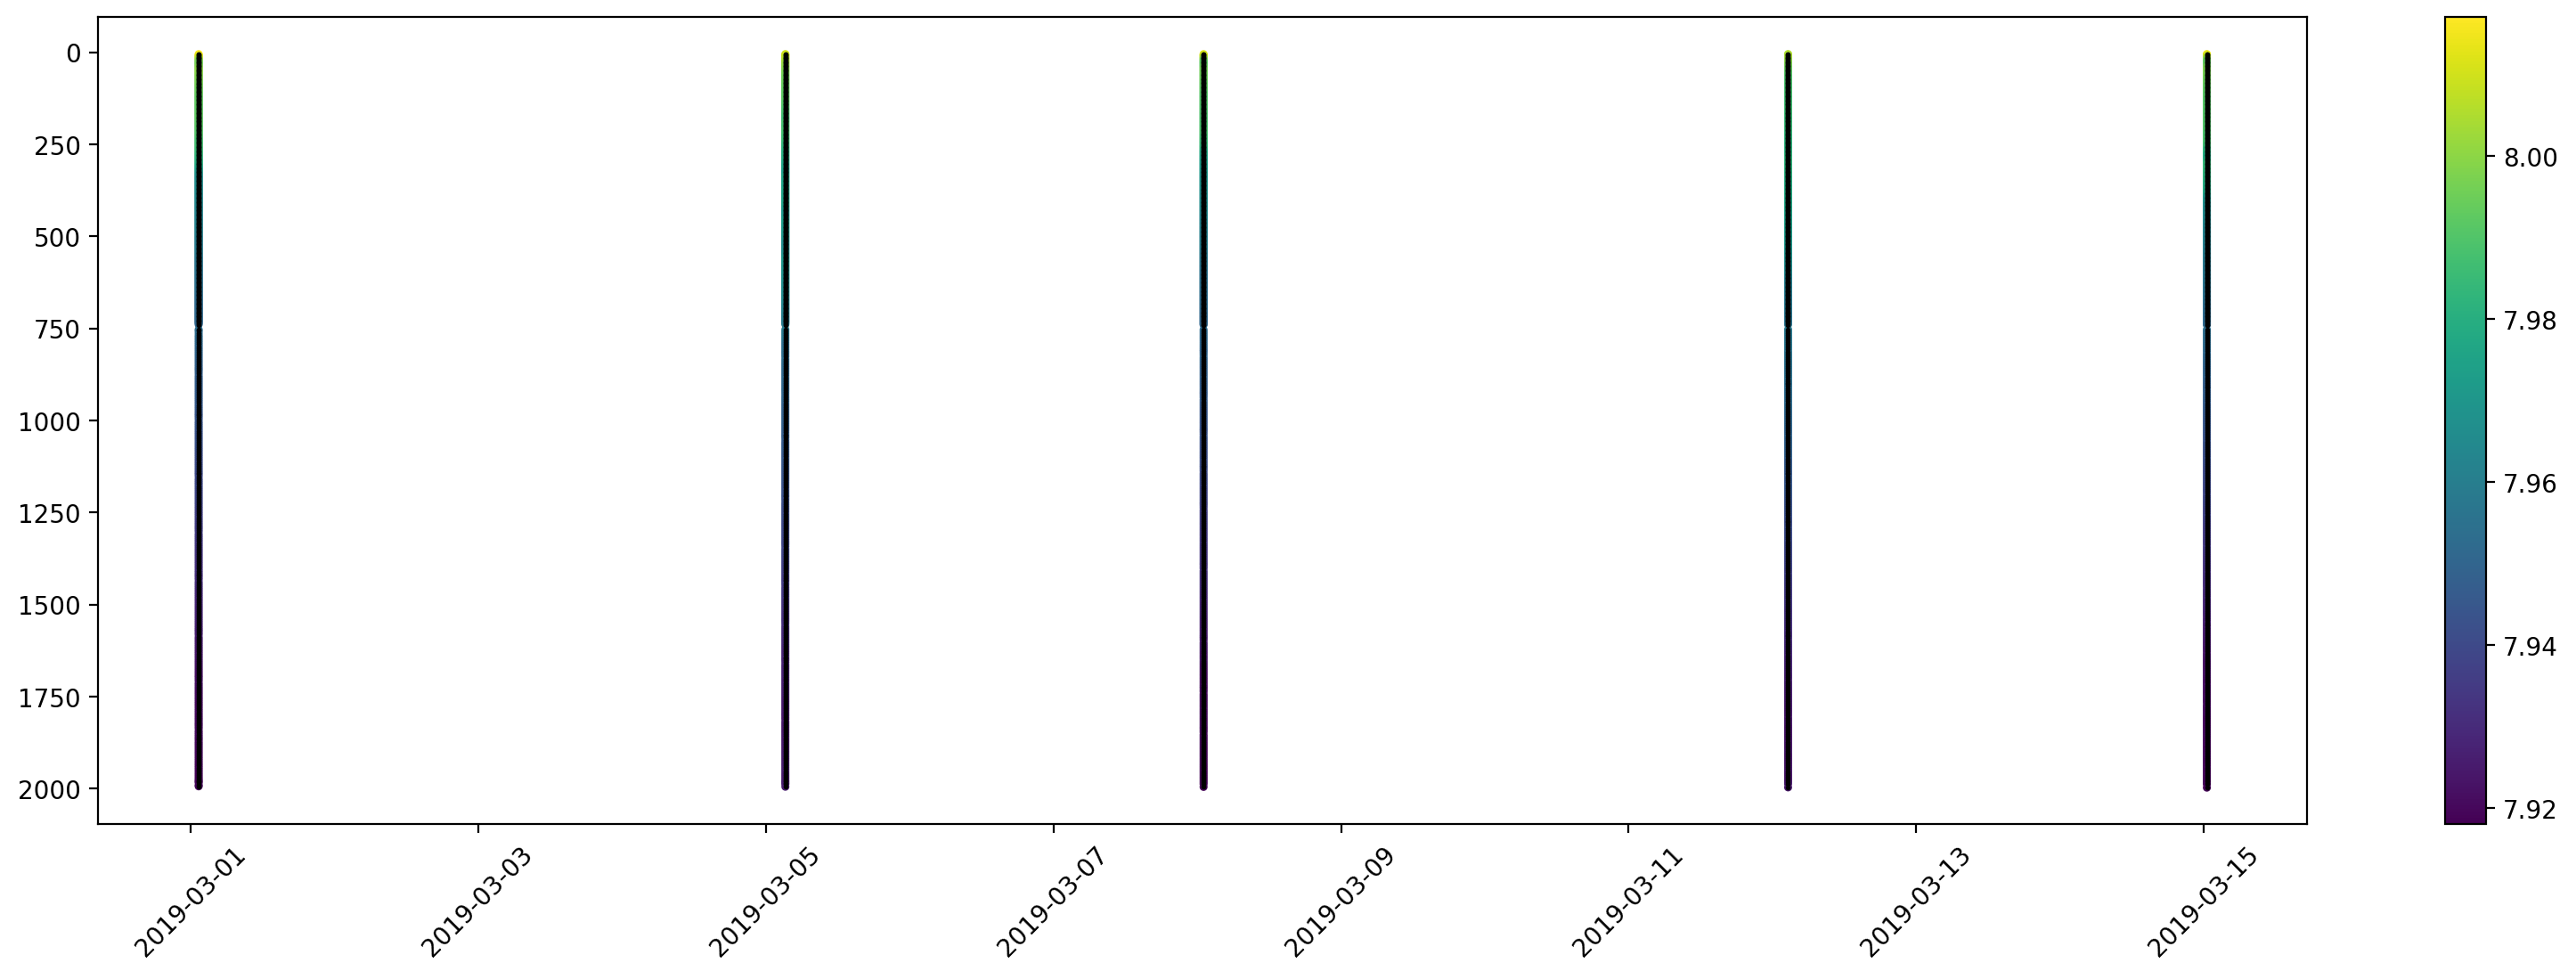

In [28]:
# latitude-depth scatterplots. Atlantic
# Mask Atlantic

plt.figure(figsize=(20,6), dpi=200)
ax = plt.axes()
sc=ax.scatter(pd.to_datetime(df_ifremer[vardict['datevec']]),
           df_ifremer[vardict['pres']],
           c=df_ifremer[vardict['ph']],
           s=5,label='BGC-Argo IFREMER')
ax.scatter(pd.to_datetime(df_emodnet[vardict['datevec']]),
           df_emodnet[vardict['pres']],
           c='k',
           s=1,label='EMODNET')
plt.xticks(rotation=45);
ax.invert_yaxis();
plt.colorbar(sc);
#ax.legend(loc='lower center')

In [2]:
# Check duplicates
dataframes=[df_emodnet,df_ifremer]
df=pd.concat(dataframes)
print(df.shape)
df.columns
isdup=df.duplicated(subset=[vardict['lat'],vardict['lon'],vardict['datevec']], keep=False)
print(sum(isdup))

NameError: name 'df_emodnet' is not defined

(3095, 13) (3090, 8)


TypeError: '([0, 5], 'PRESSURE')' is an invalid key

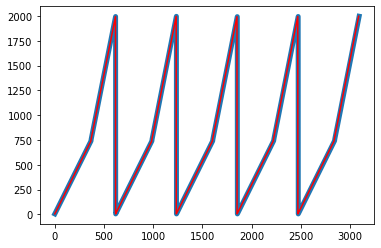

In [61]:
print(df_emodnet.shape, df_ifremer.shape)
ax=plt.axes()
ax.plot(df_emodnet[vardict['pres']], linewidth=5)
ax.plot(df_ifremer[vardict['pres']], c='r')
print(df_emodnet[[0,5],vardict['pres']])